In [3]:
!pip install d2l

     |████████████████████████████████| 81kB 2.6MB/s 


In [4]:
import pandas as pd

import torch
from torch import nn
from torch.utils import data

import matplotlib.pyplot as plt

from d2l import torch as d2l

import time

import torchvision
from torch.utils import data
from torchvision import transforms

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

import numpy as np

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

In [9]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 22, 22)
    
class Reshape2(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 41, 12)

class Reshape3(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 3, 8)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [14]:
from google.colab import files
uploaded = files.upload()

Saving VwekaInverseTuna2FT.csv to VwekaInverseTuna2FT.csv


In [7]:
#Pre-processing of the data. I generate harmonics, and price related metrics that are added as covariates.
url = 'https://raw.githubusercontent.com/josh-kennedy-7/cmu_msba_team_4_2022/main/consolidated_tuna_data_clean.csv'
dataR = pd.read_csv(url,thousands=',')

date_format = "%d/%m/%Y"
dateVector = "1/"+dataR.month.map(str)+"/"+dataR.year.map(str)
dataR = dataR.assign(date=pd.DataFrame([datetime.strptime(i, date_format)+
                                        relativedelta(day=31) for i in dateVector.values]))
basedate = pd.Timestamp('2011-4-30')

dataR = dataR.assign(elapsedD = (dataR.date - basedate).dt.days.astype(int))

for i in range(1,7):
    #The numbers can be simplified and just use the harmonics over the whole period. I adjusted 
    #the period length and starting and ending point to get relevant lower frequencies.
    harmonic = np.sin(2*np.pi*(dataR.elapsedD-63.87485419)/(1799.68952507127/i)) 
    dataR.loc[:, "harmonic_"+str(i)] = harmonic

priceDif = dataR.skipjack_tuna_price[1:].to_numpy()-dataR.skipjack_tuna_price[:-1].to_numpy()
priceDif = np.insert(priceDif, 0, [0], axis=0)
dataR = dataR.assign(ChangePrice =priceDif)

filter_size = 6

priceAvgDF = np.zeros((1,dataR.shape[0]))

for i in range(1,1+filter_size):
    zero_fill = [0 for i_1 in range(i)]
    priceAvgDF = priceAvgDF+np.insert(dataR.skipjack_tuna_price[:-i].to_numpy(), 0, zero_fill, axis=0)
priceAvgDF = priceAvgDF/[min(filter_size,i) for i in range(1,1+priceAvgDF.shape[1])]
priceAvgDF.shape, dataR.shape
dataR = dataR.assign(Price_AVG=priceAvgDF.T)
target = dataR.skipjack_tuna_price
del dataR["skipjack_tuna_price"]
del dataR["date"]
del dataR["elapsedD"]
dataR = dataR.assign(skipjack_tuna_price=target)
dataR = dataR.assign(Price_bucket_quartile=0) #I am leaving it empty because it did not yield any results, but the shape of the input is already established.

dataR

,year,month,ocean__temp_anomaly__00N.30N,ocean__total_error__00N.30N,ocean__high_error_variance__00N.30N,ocean__low_error_variance__00N.30N,ocean__bias_error_variance__00N.30N,ocean__diag_var_1__00N.30N,ocean__diag_var_2__00N.30N,ocean__diag_var_3__00N.30N,ocean__temp_anomaly__00N.90N,ocean__total_error__00N.90N,ocean__high_error_variance__00N.90N,ocean__low_error_variance__00N.90N,ocean__bias_error_variance__00N.90N,ocean__diag_var_1__00N.90N,ocean__diag_var_2__00N.90N,ocean__diag_var_3__00N.90N,ocean__temp_anomaly__20N.90N,ocean__total_error__20N.90N,ocean__high_error_variance__20N.90N,ocean__low_error_variance__20N.90N,ocean__bias_error_variance__20N.90N,ocean__diag_var_1__20N.90N,ocean__diag_var_2__20N.90N,ocean__diag_var_3__20N.90N,ocean__temp_anomaly__20S.20N,ocean__total_error__20S.20N,ocean__high_error_variance__20S.20N,ocean__low_error_variance__20S.20N,ocean__bias_error_variance__20S.20N,ocean__diag_var_1__20S.20N,ocean__diag_var_2__20S.20N,ocean__diag_var_3__20S.20N,ocean__temp_anomaly__30N.60N,ocean__total_error__30N.60N,ocean__high_error_variance__30N.60N,ocean__low_error_variance__30N.60N,ocean__bias_error_variance__30N.60N,ocean__diag_var_1__30N.60N,...,standarddeviation_sea_surface_temperature,standarddeviation_surface_pressure,standarddeviation_tauoc_normalized_stress_into_ocean,standarddeviation_tmax_period_corresponding_to_maximum_individual_wave_height,standarddeviation_total_precipitation,standarddeviation_wdw_wave_spectral_directional_width,standarddeviation_wind_10_metre_wind_speed,standarddeviation_wmb_model_bathymetry,standarddeviation_wsk_wave_spectral_kurtosis,standarddeviation_wsp_wave_spectral_peakedness,standarddeviation_wss_wave_spectral_skewness,standarddeviation_wstar_free_convective_velocity_over_the_oceans,extent_______n,extent_______s,area_______n,area_______s,seafood_fresh_frozen_processing_ppi,fao_food_price_index,fao_meat_price_index,fao_dairy_price_index,global_fish_price_index,import_price_index_fish_shellfish,global_price_of_shrimp_x,global_price_of_shrimp_y,domestic_air_cargo_volume,atlantic_air_cargo_volume,latam_air_cargo_volume,pacific_air_cargo_volume,international_air_cargo_volume,total_air_cargo_volume,harmonic_1,harmonic_2,harmonic_3,harmonic_4,harmonic_5,harmonic_6,ChangePrice,Price_AVG,skipjack_tuna_price,Price_bucket_quartile
0,2011,1,0.042499,0.007314,0.000611,0.000011,0.006692,0.183191,0.207909,0.024718,0.290972,0.005454,0.000225,0.000005,0.005225,0.138691,0.144308,0.015000,0.492440,0.004324,0.000538,0.000007,0.003779,0.131266,0.108066,0.023200,-0.135003,0.008660,0.000944,0.000002,0.007714,0.237294,0.268025,0.030730,0.389095,0.008410,0.002730,0.000025,0.005655,0.149559,...,11.479769,9328.997440,0.019431,1.197855,0.002918,0.102431,1.954787,293.738352,0.006908,0.466934,0.008007,0.299015,13.46,4.51,11.83,3.05,228.3,133.7,97.6,122.8,6.795619,119.6,7.616397,7.616397,923.950,562.053,136.695,726.570,2691.53,5040.80,-0.508745,-0.875974,-0.999539,-0.845066,-0.455526,0.060726,0,0.000000,1515,0
1,2011,2,0.075674,0.005971,0.000225,0.000011,0.005735,0.167386,0.180305,0.015000,0.195807,0.005514,0.000991,0.000005,0.004518,0.108472,0.139951,0.031479,0.305567,0.003619,0.000234,0.000007,0.003378,0.145450,0.130145,0.015306,-0.070447,0.007081,0.000225,0.000002,0.006854,0.239811,0.242997,0.015000,0.270976,0.005237,0.000225,0.000025,0.004987,0.122733,...,11.570500,9495.331822,0.019329,1.147294,0.002736,0.109426,2.126233,293.738352,0.007191,0.461330,0.008207,0.274791,14.36,2.52,12.76,1.86,228.6,137.6,100.3,130.3,6.976645,119.3,7.410835,7.410835,853.268,559.454,132.807,614.979,2481.67,4642.18,-0.422290,-0.765579,-0.965644,-0.985058,-0.820188,-0.501878,75,757.500000,1590,0
2,2011,3,0.067922,0.006240,0.000610,0.000011,0.005618,0.154367,0.179072,0.024705,0.246525,0.004890,0.000225,0.000005,0.004660,0.121731,0.131053,0.015000,0.406465,0.005148,0.001640,0.000007,0.003501,0.133907,0.093415,0.040492,-0.026836,0.007068,0.000605,0.000002,0.006460,0.215436,0.240042,0.024606,0.242060,0.007962,0.002522,0.000

torch.Size([121, 442])
torch.Size([121, 35])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 200,loss: 282196.188, elapsed time: 1.97


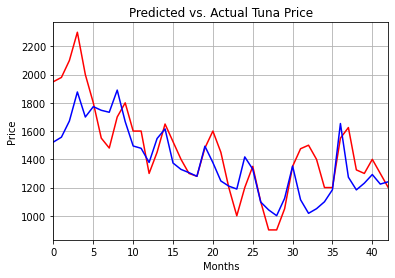

Correlation between labels and test:  0.7672587184369378
RMSE for test set:  397.25558
Number of features:  43
Shape of test set and labels:  (43,) (43,)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [25]:
import io
#dataR = pd.read_csv(io.BytesIO(uploaded['VwekaInverseTuna2FT.csv']))

#dataR = pd.read_csv("https://drive.google.com/file/d/1ba2HfYXadANSsFfXja_DymfMnZ_6V2tg/view?usp=sharing")

#dataR is the pre-processed data frame in the previous chunk of code.

features = torch.tensor(dataR.iloc[:,:484].values.astype('float32'))
print(features.shape)
features = StandardScaler().fit_transform(features)
pca = PCA(n_components=0.90) #16 covariates represent 79% of the variance.

features = torch.from_numpy(pca.fit_transform(features))
print(features.shape)

newDataSet = torch.cat((features, torch.tensor(dataR.values)[:,-10:]),1)
 
indices = torch.randperm(len(newDataSet))
#For interpolation
#train = newDataSet[indices[:int(0.5*len(newDataSet))],:-2].float().reshape(int(0.5*len(newDataSet)),3,8)
#labels = newDataSet[indices[:int(0.5*len(newDataSet))],-2].float()
#test = newDataSet[indices[int(0.5*len(newDataSet)):],:-2].float().reshape(newDataSet.shape[0]-int(0.5*len(newDataSet)),3,8)
#labelsTest = newDataSet[indices[int(0.5*len(newDataSet)):],-2].float()

#For training with older data.
#features = newDataSet[:int(0.65*len(newDataSet)),:-2].float().reshape(int(0.65*len(newDataSet)),3,8) #For use with CNNs
features = newDataSet[:int(0.65*len(newDataSet)),:-2].float().reshape(
    int(0.65*len(newDataSet)),newDataSet.shape[1]-2)
#featuresTest = newDataSet[int(0.65*len(newDataSet)):,:-2].float().reshape(newDataSet.shape[0]-int(0.65*len(newDataSet)),3,8)#For use with CNNs
featuresTest = newDataSet[int(0.65*len(newDataSet)):,:-2].float().reshape(
    newDataSet.shape[0]-int(0.65*len(newDataSet)),newDataSet.shape[1]-2)
labels = newDataSet[:int(0.65*len(newDataSet)),-2].float()
labelsTest = newDataSet[int(0.65*len(newDataSet)):,-2].float()

timer = d2l.Timer()

#CNN Network. I tried if the extra channels provided a better adjustment. In the end a simple topology (even with 1 hidden node) has the same performance.
#net = torch.nn.Sequential(Reshape3(), #The function is hard coded for the size I need... eventually should make a generic function. 
#                          nn.Conv2d(1, 6, kernel_size=1,padding=1),
#                          nn.ReLU(),
#                          nn.MaxPool2d(kernel_size=1, stride=1),
#                          nn.Conv2d(6, 32, kernel_size=2), 
#                          nn.ReLU(),
#                          nn.MaxPool2d(kernel_size=2, stride=2), 
#                          nn.Flatten(),
#                          nn.Linear(32*2*4,1))

hiddenNodes1 = 32
hiddenNodes2 = 16

net = torch.nn.Sequential(
                          nn.Linear(newDataSet.shape[1]-2,hiddenNodes1),
                          nn.ReLU(),
                          nn.Linear(hiddenNodes1,hiddenNodes2),
                          nn.ReLU(),
                          nn.Linear(hiddenNodes2,1))


#X = torch.rand(size=(1, 1, 3, 8), dtype=torch.float32) #For use with CNNs
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

#Prints the layer sizes. Usefur for CNNs
#for layer in net:
#    X = layer(X)
#    print(layer.__class__.__name__, 'output shape: \t', X.shape)

lr, num_epochs = 0.00000005, 200

batch_size = 6
train_iter = load_array((features, labels), batch_size)
test_iter = load_array((featuresTest, labelsTest), batch_size)

device = d2l.try_gpu()

net.apply(init_weights)
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.MSELoss()
timer.start()

plotInfoEpoch = []
plotInfoLoss = []

for epoch in range(num_epochs):
    accLoss = 0
    net.train()
    for i, (X, y) in enumerate(train_iter):
        optimizer.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        accLoss = accLoss + l
    plotInfoEpoch = plotInfoEpoch + [epoch]
    plotInfoLoss = plotInfoLoss +[float(accLoss)]   

print(f'epoch: {epoch + 1},'f'loss: {accLoss/(i+1):.3f}, 'f'elapsed time: {timer.stop():.2f}')

plt.title('Predicted vs. Actual Tuna Price')
plt.ylabel('Price')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(labelsTest,'r')
plt.plot(net(featuresTest).detach().numpy(),'b')
plt.show()
print("Correlation between labels and test: ", np.corrcoef(net(featuresTest).detach().numpy(), labelsTest, rowvar=False)[0,1])
print("RMSE for test set: ",np.sqrt(loss(net(featuresTest), labelsTest).detach().numpy()))
print("Number of features: ",newDataSet.shape[1]-2)
print("Shape of test set and labels: ",net(featuresTest).detach().numpy().reshape(len(featuresTest)).shape,labelsTest.numpy().shape)
ResultsDump = pd.DataFrame([net(featuresTest).detach().numpy().reshape(len(featuresTest)),labelsTest.numpy()]).T
ResultsDump.columns = ["Predicted","Actual Target"]
#print(ResultsDump)